# NN Model
#### cv score :  0.5468884688090737 (5 folds)
#### cv score :  ?? (10 folds)

In [1]:
import sys
sys.path.append('../')
import pandas as pd
import numpy as np
import sklearn
from Functions import prepro, NNModel
import warnings

import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from tensorflow.keras.callbacks import EarlyStopping


random.seed(0)

pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500)
warnings.filterwarnings('ignore')

In [2]:
train_df = pd.read_csv("../../data/Processed/train2.csv")
test_df = pd.read_csv("../../data/Processed/test2.csv")
print(train_df.shape)
print(test_df.shape)

(132250, 193)
(28340, 192)


### 武器の情報を個人ごとからチームごとに変える
category1, 2を落とす、

他のカテゴリをチームごとにする

reskinそのまま

In [3]:
y = train_df["y"]
train_df = train_df.drop("y", axis=1)

In [4]:
# add info about numeric column

num_cols = ["level", "range", "rapid-", "atack"]

#train_df = prepro.flat(train_df, num_cols)
#test_df = prepro.flat(test_df, num_cols)

train_df = prepro.add_numeric_info(train_df, num_cols)
test_df = prepro.add_numeric_info(test_df, num_cols)

In [5]:
# add team info

train_df,  test_df = prepro.addTeamInfo(train_df, test_df, cols=["special", "subweapon", "category1", "category2", "mainweapon"])

(160590, 240)
special-A
special-B
subweapon-A
subweapon-B
category1-A
category1-B
category2-A
category2-B
mainweapon-A
mainweapon-B
(160590, 424)
complete


In [6]:
# add disconnection info

train_df = prepro.add_disconnection(train_df)
test_df = prepro.add_disconnection(test_df)

In [7]:
# categorize team

categorize_col = ["category1", "category2", "subweapon", "special", "mainweapon"]
for col in categorize_col:
    print(col)
    train_df_, test_df_ = prepro.categorize_team(train_df, test_df, col)

category1
category2
subweapon
special
mainweapon


In [8]:
#target encoding

#cat_tgtenc_cols = ["mode", "stage", "team-category1-A", "team-category1-B", 
#                  "team-category2-A", "team-category2-B", "team-subweapon-A", "team-subweapon-B", "team-special-A", "team-special-B"]

cat_tgtenc_cols = ["mode", "stage", "team-category1-A", "team-category1-B"]
for col in cat_tgtenc_cols:
    print(col)
    train_df, test_df = prepro.target_encoding(train_df, test_df, y, col, "y")
    

mode
fold 0
fold 1
fold 2
fold 3
fold 4
stage
fold 0
fold 1
fold 2
fold 3
fold 4
team-category1-A
fold 0
fold 1
fold 2
fold 3
fold 4
team-category1-B
fold 0
fold 1
fold 2
fold 3
fold 4


In [9]:
# make input

# categorical_feature = train_df.dtypes[train_df.dtypes == "object"].index.to_list()

drop_cols = ["id", "lobby", "lobby-mode",  "period", "game-ver", "A1-weapon", "A2-weapon", "A3-weapon", "A4-weapon", \
              "B1-weapon", "B2-weapon", "B3-weapon", "B4-weapon"]

categorical_feature = [col for col in train_df.dtypes[train_df.dtypes == "object"].index.to_list() if col not in drop_cols]
X, test_X = prepro.make_input(train_df, test_df, drop_cols, categorical_encode=True, verbose=True)

X[categorical_feature] = X[categorical_feature].astype("category")

id
period
game-ver
lobby-mode
lobby
mode
stage
A1-weapon
A1-rank
A1-level
A2-weapon
A2-rank
A2-level
A3-weapon
A3-rank
A3-level
A4-weapon
A4-rank
A4-level
B1-weapon
B1-rank
B1-level
B2-weapon
B2-rank
B2-level
B3-weapon
B3-rank
B3-level
B4-weapon
B4-rank
B4-level
category1-A1
category2-A1
subweapon-A1
special-A1
mainweapon-A1
reskin-A1
range-main-A1
atack-main-A1
rapid-main-A1
vote-main-A1
fav-main-A1
damage_min-sub-A1
damage_max-sub-A1
ink-sub-A1
install_num-sub-A1
good-sub-A1
damage_min-special-A1
damage_max-special-A1
duration-special-A1
good-special-A1
category1-A2
category2-A2
subweapon-A2
special-A2
mainweapon-A2
reskin-A2
range-main-A2
atack-main-A2
rapid-main-A2
vote-main-A2
fav-main-A2
damage_min-sub-A2
damage_max-sub-A2
ink-sub-A2
install_num-sub-A2
good-sub-A2
damage_min-special-A2
damage_max-special-A2
duration-special-A2
good-special-A2
category1-A3
category2-A3
subweapon-A3
special-A3
mainweapon-A3
reskin-A3
range-main-A3
atack-main-A3
rapid-main-A3
vote-main-A3
fav-main-A

In [10]:
# 全データを5つに分割
SIZE = X.shape[0]
K = 5

folds = prepro.make_kfolds(SIZE, K)
print(len(folds))
for i, fold in enumerate(folds):
    print("fold ", i+1, " size is ", len(fold))
    

    
if SIZE != len(set(sum(folds, []))):
    print("error is occuring in spliting")
else :
    print("successfully split")


5
fold  1  size is  26450
fold  2  size is  26450
fold  3  size is  26450
fold  4  size is  26450
fold  5  size is  26450
successfully split


In [11]:
THRESHOLD = 0.50
models = []
cv_scores = []
temp = 0
train_pred = []

all_indices = sum(folds, [])
for i in range(K):
    print("======================== fold {} ========================".format(i+1))
    valid_indices = folds[i]
    train_indices = list(set(all_indices) - set(valid_indices))
    # print("train ", len(train_indices), " , valid ", len(valid_indices))
    train_X = X.iloc[train_indices]
    train_y = y.iloc[train_indices]
    valid_X = X.iloc[valid_indices]
    valid_y = y.iloc[valid_indices]
    
    
    model = NNModel.make_model(X, test_X, categorical_feature)
    #model = make_model(X, test_X, categorical_feature)
    
    
    train_X = NNModel.prepro_nn(train_X, categorical_feature)
    train_y = train_y.values.reshape(-1, 1)
    valid_X = NNModel.prepro_nn(valid_X, categorical_feature)
    valid_y = valid_y.values.reshape(-1, 1)
    
    
    

    cb = EarlyStopping(monitor='val_loss', patience=1)

    model.fit(
        train_X, 
        train_y,
        batch_size=64,
        epochs=10,
        verbose=1,
        callbacks=[cb],
        validation_data=(valid_X, valid_y),
    )
    
    pred = model.predict(valid_X)
    pred = np.where(pred < THRESHOLD, 0, 1)
    train_pred.append(pred)
    temp += np.sum(pred)
    
    score = accuracy_score(pred, valid_y)
    
    models.append(model)
    cv_scores.append(score)
    
    
print("cv score : ", np.mean(cv_scores))    
print("cv ratio : ", temp / SIZE)

======================== fold 1 ========================
Train on 105800 samples, validate on 26450 samples
Epoch 1/10
105800/105800 [==============================] - 74s 698us/sample - loss: 3.4908 - val_loss: 1.0312
Epoch 2/10
105800/105800 [==============================] - 67s 632us/sample - loss: 0.7788 - val_loss: 0.6993
Epoch 3/10
105800/105800 [==============================] - 71s 666us/sample - loss: 0.6933 - val_loss: 0.6940
Epoch 4/10
105800/105800 [==============================] - 73s 693us/sample - loss: 0.6924 - val_loss: 0.6960
======================== fold 2 ========================
Train on 105800 samples, validate on 26450 samples
Epoch 1/10
105800/105800 [==============================] - 85s 803us/sample - loss: 3.3845 - val_loss: 0.9738
Epoch 2/10
105800/105800 [==============================] - 78s 740us/sample - loss: 0.7605 - val_loss: 0.6950
Epoch 3/10
105800/105800 [==============================] - 77s 725us/sample - loss: 0.6933 - val_loss: 0.6908
Epoch 4

0.5072393467162138
0.5082054337398554
0.5157983967007763
0.5074618816712244
0.5037478428788814
0.5084905458825865


array([[<AxesSubplot:title={'center':'pred'}>]], dtype=object)

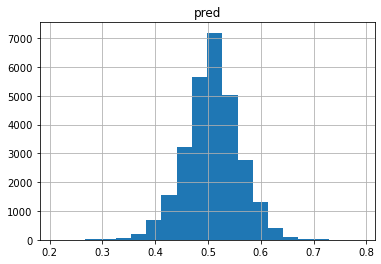

In [12]:
preds = []
test_X = NNModel.prepro_nn(test_X, categorical_feature)

for i in range(K):
    model = models[i]
    pred = model.predict(test_X, batch_size=128).reshape(-1, )
    preds.append(pred)
    print(np.sum(pred) / pred.shape[0])
    
preds = np.array(preds)
preds = np.mean(preds, axis=0)
print(np.sum(preds) / preds.shape[0])


temp = pd.DataFrame({"pred":preds})
temp.hist(bins=20)

In [13]:
preds = np.where(preds < THRESHOLD, 0, 1)
print(np.sum(preds) / preds.shape[0])

submit_df = pd.DataFrame({'y': preds})
submit_df.index.name = 'id'
submit_df.to_csv('../Submissions/submission_NN_1_{}.csv'.format(K))

0.5807339449541284


# モデル解釈

In [ ]:
importance = pd.DataFrame(models[1].feature_importance(), index=X.columns, columns=['importance']).sort_values('importance', ascending=False)
display(importance[:50])

In [ ]:
importance["importance"].sum()

In [ ]:
train_df["pred"] = 0
train_df["y"] = y.values
for i in range(K):
    train_df["pred"].iloc[folds[i]] = train_pred[i].reshape(-1, )

In [ ]:
result_df = train_df[train_df["y"] != train_df["pred"]]

In [ ]:
print(result_df[result_df["mode"] == "nawabari"].shape[0]/result_df.shape[0])
print(result_df[result_df["mode"] == "hoko"].shape[0]/result_df.shape[0])
print(result_df[result_df["mode"] == "asari"].shape[0]/result_df.shape[0])
print(result_df[result_df["mode"] == "area"].shape[0]/result_df.shape[0])
print(result_df[result_df["mode"] == "yagura"].shape[0]/result_df.shape[0])

In [ ]:
result_df

In [ ]:
model = NNModel.make_model(X, categorical_feature)

train_data = NNModel.prepro_nn(X, categorical_feature)
model.fit(train_data, y.values.reshape(-1, 1), epochs=2)

In [ ]:
def make_model(df1, df2, categorical_feature):
    all_df = pd.concat([df1, df2])
    numeric_feature_num = int(df1.columns .shape[0]) - len(categorical_feature)
    #numeric_feature_num = int((df.dtypes == float).sum() + (df.dtypes == int).sum())
    #print(numeric_feature_num)
    num_input = Input(numeric_feature_num, )
    inputs = []
    embs = []
    embedding_dim = 6
    for col in categorical_feature:
        value_size = all_df[col].unique().shape[0]
        input_cat = Input(1,)
        #emb = Embedding(input_dim=value_size, output_dim=embedding_dim)(input_cat)
        emb = Embedding(input_dim=value_size, output_dim=int(np.log2(value_size))+1)(input_cat)
        emb = Flatten()(emb)
        #emb = Dropout(0.2)(emb)
        #emb = Dense(2, kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01))(emb)
        #emb = Flatten()(emb)

        inputs.append(input_cat)
        embs.append(emb)

    concat = Concatenate()([num_input, *embs])

    outputs = (Dense(1024, kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))(concat)
    outputs = (Activation('relu'))(outputs)
    outputs = (Dropout(.4))(outputs)
    #outputs = (Dense(256))(outputs)
    #outputs = (Activation('relu'))(outputs)
    #outputs = (Dropout(.4))(outputs)
    outputs = (Dense(128, kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))(outputs)
    outputs = (Activation('relu'))(outputs)
    outputs = (Dropout(.4))(outputs)
    outputs = (Dense(1))(outputs)
    outputs = (Activation('sigmoid'))(outputs)
    model = Model(inputs=[num_input, *inputs], outputs=[outputs])
    model.compile(optimizer=Adam(lr=0.0001), loss="binary_crossentropy")
    #display(model.summary())

    return model

In [ ]:
cat_values = {}
for col in 